## Holywood Network

### Question and problem definition
* let's analyze which are the most relevant actors in each decade and how it evolved from the 90s to the 10s.

In [4]:
import json
import pandas as pd
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

Our data base is one taken from the Internet Movie Database (IMDB). Specifically, we use a dataset compiled by the administrators of the [Oracle of Bacon website](https://oracleofbacon.org/)

### 1. Aquire Data

In [5]:
dicts = []
with open('out_test_two.txt', encoding='utf8') as file:
    for line in file:
        dicts.append(json.loads(line))
        
df = pd.DataFrame(dicts)

df.head(5)

,title,cast,directors,producers,companies,year
0,Actrius,"[Núria Espert, Rosa Maria Sardà, Anna Lizaran,...",[Ventura Pons],[Ventura Pons],[Buena Vista International],1997.0
1,Army of Darkness,"[Bruce Campbell, Embeth Davidtz, Marcus Gilber...",[Sam Raimi],[Robert Tapert],[Dino De Laurentiis|Dino De Laurentiis Communi...,1992.0
2,The Birth of a Nation,"[Lillian Gish, Mae Marsh, Henry B. Walthall, M...",[D. W. Griffith],"[D. W. Griffith, Harry Aitken]","[David W. Griffith Corp., Epoch Producing Co.]",1915.0
3,Blade Runner,"[Harrison Ford, Rutger Hauer, Sean Young, Edwa...",[Ridley Scott],[Michael Deeley],"[The Ladd Company, Shaw Brothers, Blade Runner...",1982.0
4,Blazing Saddles,"[Cleavon Little, Gene Wilder, Slim Pickens, Al...",[Mel Brooks],[Michael Hertzberg],"[Crossbow Productions, Warner Bros.]",1974.0


### 2. Baseline

In [6]:
#change the year formart
df['year'] = df['year'].fillna(0.0).astype(int)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146725 entries, 0 to 146724
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      146725 non-null  object
 1   cast       146725 non-null  object
 2   directors  140011 non-null  object
 3   producers  112218 non-null  object
 4   companies  111651 non-null  object
 5   year       146725 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 6.2+ MB


In [8]:
df.isnull().sum()

title            0
cast             0
directors     6714
producers    34507
companies    35074
year             0
dtype: int64

We have a lot of null values in the directors, producers and companies categories, but these are not columns that we are going to use, so there is no need for correction.

In [9]:
#see if the database is updated
df['year'].value_counts().sort_index()

0       8223
1861       1
1871       1
1887       1
1888       1
        ... 
2020    1731
2021    1462
2022     149
2023      10
2024       1
Name: year, Length: 141, dtype: int64

* The data is updated, but we see that we have data with year = 0. We are going to drop those rows
* I also saw in the raw data that we have a few rows with an empty list as a cast. As that is our main variable, we are going to drop that as well.

### 3. Correcting

In [10]:
df = df[df['cast'].map(lambda d: len(d)) > 0]
df = df.drop(df[df.year == 0].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130304 entries, 0 to 146723
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      130304 non-null  object
 1   cast       130304 non-null  object
 2   directors  129269 non-null  object
 3   producers  104780 non-null  object
 4   companies  105045 non-null  object
 5   year       130304 non-null  int32 
dtypes: int32(1), object(5)
memory usage: 6.5+ MB


* Let us have a df with only our variables of interest
* I'm also going to make a copy of the cast columns, so we have a source and a target column for the networkx graph

In [11]:
df_copy = df[['title', 'cast', 'year']].copy()
df_copy['pairs'] = df_copy['cast']

In [12]:
df_copy = df_copy.explode('cast')
df_copy.head()

,title,cast,year,pairs
0,Actrius,Núria Espert,1997,"[Núria Espert, Rosa Maria Sardà, Anna Lizaran,..."
0,Actrius,Rosa Maria Sardà,1997,"[Núria Espert, Rosa Maria Sardà, Anna Lizaran,..."
0,Actrius,Anna Lizaran,1997,"[Núria Espert, Rosa Maria Sardà, Anna Lizaran,..."
0,Actrius,Mercè Pons,1997,"[Núria Espert, Rosa Maria Sardà, Anna Lizaran,..."
1,Army of Darkness,Bruce Campbell,1992,"[Bruce Campbell, Embeth Davidtz, Marcus Gilber..."


In [13]:
df_copy = df_copy.explode('pairs')
df_copy.head()

,title,cast,year,pairs
0,Actrius,Núria Espert,1997,Núria Espert
0,Actrius,Núria Espert,1997,Rosa Maria Sardà
0,Actrius,Núria Espert,1997,Anna Lizaran
0,Actrius,Núria Espert,1997,Mercè Pons
0,Actrius,Rosa Maria Sardà,1997,Núria Espert


In [14]:
# drop rows where the cast and the pairs are the same name
df_copy = df_copy[df_copy['cast'] != df_copy['pairs']]
df_copy.reset_index(drop=True, inplace=True)

In [15]:
# drop rows where the pair [cast,pairs] is the same as [pairs, cast], as we are not going to work with a directional graph
out = df_copy[~df_copy[['cast', 'pairs']].apply(frozenset, axis=1).duplicated()]
out.head()

,title,cast,year,pairs
0,Actrius,Núria Espert,1997,Rosa Maria Sardà
1,Actrius,Núria Espert,1997,Anna Lizaran
2,Actrius,Núria Espert,1997,Mercè Pons
4,Actrius,Rosa Maria Sardà,1997,Anna Lizaran
5,Actrius,Rosa Maria Sardà,1997,Mercè Pons


In [16]:
count = Counter(out['cast'])
count.most_common(5)

[('Nassar (actor)|Nassar', 2675),
 ('Prakash Raj', 2273),
 ('Mammootty', 1917),
 ('Brahmanandam', 1840),
 ('Andy Lau', 1822)]

Ignoring the numbers for a second, I see that 4 out of 5 of these actors are well known in the indian cinema. Our analysis is for the Hollywood context, therefore is best if we filter the actors columns. 
As we don't have a country column, we are going to use the [Top 1000 Actors and Actresses](https://www.imdb.com/list/ls058011111/) list from IMDB.

In [17]:
df_american_actors = pd.read_csv('Top 1000 Actors and Actresses.csv', index_col=None)
df_american_actors.head()

,Name
0,Robert De Niro
1,Jack Nicholson
2,Marlon Brando
3,Denzel Washington
4,Katharine Hepburn


In [18]:
out_final = out[out['cast'].isin(df_american_actors['Name'])]
out_final.reset_index(drop=True, inplace=True)

In [19]:
out_final.head()

,title,cast,year,pairs
0,The Birth of a Nation,Lillian Gish,1915,Mae Marsh
1,The Birth of a Nation,Lillian Gish,1915,Henry B. Walthall
2,The Birth of a Nation,Lillian Gish,1915,Miriam Cooper
3,The Birth of a Nation,Lillian Gish,1915,Ralph Lewis (actor)|Ralph Lewis
4,The Birth of a Nation,Lillian Gish,1915,George Siegmann


In [20]:
out_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491474 entries, 0 to 491473
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   title   491474 non-null  object
 1   cast    491474 non-null  object
 2   year    491474 non-null  int32 
 3   pairs   491474 non-null  object
dtypes: int32(1), object(3)
memory usage: 13.1+ MB


* We still have almost 500k movies in our dataset. Maybe for our visualization exercise we are going to need to filter the titles of interest a little more 

### 5. Charting and 6. Creating

* Lets do a copy of our final dataset, but without the pairs column, just so we can analized a bit more without the cast duplicates

In [40]:
out_final_titles = out_final[['title', 'cast', 'year']].copy()
out_final_titles = out_final_titles.drop_duplicates(subset=['cast', 'title'], keep='first')
out_final_titles.sort_values(by='cast')

,title,cast,year
34879,The Core,Aaron Eckhart,2003
301080,Neverwas,Aaron Eckhart,2005
96922,Erin Brockovich (film),Aaron Eckhart,2000
52794,In the Company of Men,Aaron Eckhart,1997
254574,No Reservations (film),Aaron Eckhart,2007
...,...,...,...
231279,Manic (2001 film),Zooey Deschanel,2001
299087,Yes Man (film),Zooey Deschanel,2008
343260,Do It Again (film),Zooey Deschanel,2009
346654,Our Idiot Brother,Zooey Deschanel,2011


In [41]:
# TOP 5 actors with most films
count = Counter(out_final_titles['cast'])
count.most_common(5)

[('Mohanlal', 287),
 ('Christopher Lee', 164),
 ('Lionel Barrymore', 164),
 ('John Wayne', 150),
 ('Gérard Depardieu', 143)]

Creating a 'decade' feature:

In [42]:
conditions = [
    (out_final_titles['year'] < 1990),
    (out_final_titles['year'] >= 1990) & (out_final_titles['year'] < 2000),
    (out_final_titles['year'] >= 2000) & (out_final_titles['year'] < 2010),
    (out_final_titles['year'] >= 2010) & (out_final_titles['year'] < 2020),
    (out_final_titles['year'] >= 2020)]
choices = ['<90', '90s', '00s', '10s', '20s']
out_final_titles['decade'] = np.select(conditions, choices)
out_final_titles.head()

,title,cast,year,decade
0,The Birth of a Nation,Lillian Gish,1915,<90
44,The Birth of a Nation,Donald Crisp,1915,<90
71,Blade Runner,Harrison Ford,1982,<90
83,Blade Runner,Rutger Hauer,1982,<90
94,Blade Runner,Edward James Olmos,1982,<90


In [43]:
# number of movies per decade
out_final_titles.decade = out_final_titles.decade.astype("category")
out_final_titles.groupby('decade')['title'].count()

decade
00s     9576
10s    10366
20s     1267
90s     6628
<90    16601
Name: title, dtype: int64

In [45]:
# TOP 5 actors with most films per decade
group_by_decade = out_final_titles['cast'].groupby(out_final_titles['decade']).value_counts()
group_by_decade.groupby('decade').nlargest(5)

decade  decade  cast              
00s     00s     Mohanlal               56
                Gérard Depardieu       41
                Irrfan Khan            38
                Samuel L. Jackson      36
                Steve Buscemi          35
10s     10s     James Franco           60
                Mohanlal               52
                Danny Glover           48
                Nicolas Cage           40
                Liam Neeson            35
20s     20s     Michelle Yeoh           8
                Willem Dafoe            8
                Ben Affleck             7
                Bruce Willis            7
                Andrea Riseborough      6
90s     90s     Mohanlal               55
                Samuel L. Jackson      42
                Harvey Keitel          36
                Christopher Walken     33
                Steve Buscemi          33
<90     <90     Lionel Barrymore      164
                John Wayne            149
                Boris Karloff         139

* Now a dataset without titles duplicates, so we can plot a histogram

In [33]:
out_final_movies = out_final_titles
out_final_movies

decade  cast             
00s     Mohanlal             56
        Gérard Depardieu     41
        Irrfan Khan          38
        Samuel L. Jackson    36
        Steve Buscemi        35
                             ..
<90     Thora Birch           1
        Tim Allen             1
        Tobey Maguire         1
        Tom Wilkinson         1
        Vincent Gallo         1
Name: cast, Length: 3388, dtype: int64

In [46]:
out_final_movies = out_final_titles[['title', 'year', 'decade']].copy()
out_final_movies = out_final_movies.drop_duplicates(subset = "title")
out_final_movies.reset_index(drop=True, inplace=True)
out_final_movies.head()

,title,year,decade
0,The Birth of a Nation,1915,<90
1,Blade Runner,1982,<90
2,Blazing Saddles,1974,<90
3,Blue Velvet (film),1986,<90
4,Buffy the Vampire Slayer (film),1992,90s


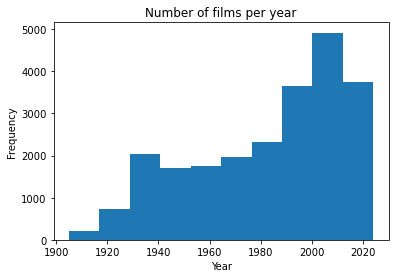

In [47]:
plt.hist(out_final_movies['year'])
plt.xlabel("Year")
plt.ylabel("Frequency")
plt.title("Number of films per year")
plt.show()

In [56]:
# Pivot table
pd.pivot_table(out_final_movies, values='title', index='decade', aggfunc='count').sort_values(by=['title'],ascending=False)

,title
decade,
<90,10940
10s,4391
00s,4026
90s,3032
20s,630


* 32% increase in movie releases from 90s to 00s, and 9% from the 00s to the 10s 

### 7. Converting

In [160]:
# Loading the Bokeh package
from bokeh.io import output_notebook, show, save
from bokeh.models import Range1d, Circle, ColumnDataSource, MultiLine, EdgesAndLinkedNodes, NodesAndLinkedEdges, LabelSet
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
from bokeh.palettes import Blues8, Inferno8, Purples8, PuRd8, Plasma8
from bokeh.transform import linear_cmap
from networkx.algorithms.community import greedy_modularity_communities

output_notebook()

Loading BokehJS ...

For our visualization exercise, as I mentioned before, we are going to filter our datasets using box office records from the [The Numbers](https://www.the-numbers.com/box-office-records/worldwide/all-movies/cumulative/). I'm only going to use the 100 biggest worldwide revenues movies from each decade, excluding animations.

In [263]:
most_revenue_titles_90s = pd.read_excel('most_revenue_titles.xlsx', index_col='index')
most_revenue_titles_00s = pd.read_excel('most_revenue_titles_00s.xlsx', index_col='index')
most_revenue_titles_10s = pd.read_excel('most_revenue_titles_10s.xlsx', index_col='index')

#example
most_revenue_titles_90s.head()

,titles
index,
0,Titanic (1997 film)
1,Jurassic Park
2,Star Wars: Episode I â€“ The Phantom Menace
3,Independence Day (1996 film)
4,Forrest Gump


In [276]:
# Separating the data in the decades of interest
df_90s = out_final[(out_final.year >= 1990) & (out_final.year < 2000)]
df_90s = df_90s[df_90s['title'].isin(most_revenue_titles_90s['titles'])]

df_00s = out_final[(out_final.year >= 2000) & (out_final.year < 2010)]
df_00s = df_00s[df_00s['title'].isin(most_revenue_titles_00s['titles'])]

df_10s = out_final[(out_final.year >= 2010) & (out_final.year < 2020)]
df_10s = df_10s[df_10s['title'].isin(most_revenue_titles_10s['titles'])]

In [392]:
# Creating Networkx Graphs
G_90s = nx.from_pandas_edgelist(df_90s, 'cast', 'pairs', 'title')
G_00s = nx.from_pandas_edgelist(df_00s, 'cast', 'pairs', 'title')
G_10s = nx.from_pandas_edgelist(df_10s, 'cast', 'pairs', 'title')

In [393]:
#Choose a title
title = '90s Hollywood Network'

#Establish which categories will appear when hovering over each node
HOVER_TOOLTIPS = [("Actor", "@index")]

#Create a plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object with spring layout
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html
network_graph = from_networkx(G_90s, nx.spring_layout, scale=10, center=(0, 0))

#Set node size and color
network_graph.node_renderer.glyph = Circle(size=15, fill_color='skyblue')

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

#Add network graph to the plot
plot.renderers.append(network_graph)

show(plot)

* We still have a very 'hairball' like graph. Lets make some adjustments

**To classify which nodes/actors are important, we are going to use the node degree, which is the number of edges adjacent to the node. In doing so, we are assuming that the actors who participated in the most successful/top revenue films were the most rated and, therefore, the most relevant within the reference decade.**

In [394]:
# Create degrees attribute
degrees_90s = dict(nx.degree(G_90s))
nx.set_node_attributes(G_90s, name='degree', values=degrees_90s)

# Remove from graph those with little relevance (or degree <= 20)
remove = [node for node,degree in dict(G_90s.degree()).items() if degree <= 25]
G_90s.remove_nodes_from(remove)

In [395]:
# Attributes from G network to size and color
size_by_this_attribute = 'degree'
color_by_this_attribute = 'degree'

#Color palette
color_palette = Inferno8 

#Choose a title
title = '90s Hollywood Network'

#Categories that will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Actor", "@index"),
        ("Degree", "@degree")
]

#Create plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G_90s, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

#Add labels:
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G_90s.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.5, text_align='center')
plot.renderers.append(labels)

show(plot)
save(plot, filename="90s_with_labels.html")

'C:\\Users\\biby_\\Desktop\\Cursos\\DataCamp\\Movies\\90s_with_labels.html'

In [396]:
top_degrees_90s = sorted(degrees_90s.items(), key=lambda x:x[1], reverse=True)[0:10]
top_degrees_90s

[('Jim Carrey', 79),
 ('Tom Hanks', 77),
 ('Bruce Willis', 77),
 ('Kevin Costner', 77),
 ('Tom Cruise', 73),
 ('Joe Pesci', 66),
 ('Cuba Gooding Jr.', 65),
 ('Paul Giamatti', 63),
 ('Tommy Lee Jones', 61),
 ('Bill Paxton', 59)]

* These are the top 10 actors of the 90s era

Lets do the same for the 00s and the 10s

In [397]:
# Create degrees attribute
degrees_00s = dict(nx.degree(G_00s))
nx.set_node_attributes(G_00s, name='degree', values=degrees_00s)

# Remove from graph those with little relevance (or degree <= 20)
remove = [node for node,degree in dict(G_00s.degree()).items() if degree <= 20]
G_00s.remove_nodes_from(remove)

In [398]:
# Attributes from G network to size and color
size_by_this_attribute = 'degree'
color_by_this_attribute = 'degree'

#Color palette
color_palette = Inferno8 

#Choose a title
title = '00s Hollywood Network'

#Categories that will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Actor", "@index"),
        ("Degree", "@degree")
]

#Create plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G_00s, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

#Add labels:
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G_00s.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.5, text_align='center')
plot.renderers.append(labels)

show(plot)
save(plot, filename="00s_with_labels.html")

'C:\\Users\\biby_\\Desktop\\Cursos\\DataCamp\\Movies\\00s_with_labels.html'

In [399]:
top_degrees_00s = sorted(degrees_00s.items(), key=lambda x:x[1], reverse=True)[0:10]
top_degrees_00s

[('Tom Cruise', 101),
 ('Hugo Weaving', 96),
 ('Ian McKellen', 91),
 ('Orlando Bloom', 79),
 ('Shia LaBeouf', 76),
 ('Jon Voight', 75),
 ('Stellan Skarsgård', 67),
 ('Michael Caine', 66),
 ('Ben Stiller', 64),
 ('Will Smith', 63)]

In [400]:
# Create degrees attribute
degrees_10s = dict(nx.degree(G_10s))
nx.set_node_attributes(G_10s, name='degree', values=degrees_10s)

# Remove from graph those with little relevance (or degree <= 20)
remove = [node for node,degree in dict(G_10s.degree()).items() if degree <= 20]
G_10s.remove_nodes_from(remove)

In [401]:
# Attributes from G network to size and color
size_by_this_attribute = 'degree'
color_by_this_attribute = 'degree'

#Color palette
color_palette = Inferno8 

#Choose a title
title = '10s Hollywood Network'

#Categories that will appear when hovering over each node
HOVER_TOOLTIPS = [
       ("Actor", "@index"),
        ("Degree", "@degree")
]

#Create plot — set dimensions, toolbar, and title
plot = figure(tooltips = HOVER_TOOLTIPS,
              tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
            x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), title=title)

#Create a network graph object
# https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.drawing.layout.spring_layout.html\
network_graph = from_networkx(G_10s, nx.spring_layout, scale=10, center=(0, 0))

#Set node sizes and colors according to node degree (color as spectrum of color palette)
minimum_value_color = min(network_graph.node_renderer.data_source.data[color_by_this_attribute])
maximum_value_color = max(network_graph.node_renderer.data_source.data[color_by_this_attribute])
network_graph.node_renderer.glyph = Circle(size=size_by_this_attribute, fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))

#Set edge opacity and width
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.5, line_width=1)

plot.renderers.append(network_graph)

#Add labels:
x, y = zip(*network_graph.layout_provider.graph_layout.values())
node_labels = list(G_10s.nodes())
source = ColumnDataSource({'x': x, 'y': y, 'name': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='name', source=source, background_fill_color='white', text_font_size='10px', background_fill_alpha=.5, text_align='center')
plot.renderers.append(labels)

show(plot)
save(plot, filename="10s_with_labels.html")

'C:\\Users\\biby_\\Desktop\\Cursos\\DataCamp\\Movies\\10s_with_labels.html'

In [402]:
top_degrees_10s = sorted(degrees_10s.items(), key=lambda x:x[1], reverse=True)[0:10]
top_degrees_10s

[('Mark Wahlberg', 82),
 ('Stanley Tucci', 81),
 ('Josh Duhamel', 72),
 ('Bradley Cooper', 61),
 ('John Turturro', 61),
 ('Tyrese Gibson', 61),
 ('Ken Watanabe', 57),
 ('Benedict Cumberbatch', 57),
 ('Jennifer Lawrence', 56),
 ('Robert Downey Jr.', 55)]

### 8. Comparing

In [403]:
df_degrees_90 = pd.DataFrame.from_dict(degrees_90s, orient='index', columns=['degree_90s'])
df_degrees_00 = pd.DataFrame.from_dict(degrees_00s, orient='index', columns=['degree_00s'])
df_degrees_10 = pd.DataFrame.from_dict(degrees_10s, orient='index', columns=['degree_10s'])

In [404]:
result_degrees = pd.concat([df_degrees_90, df_degrees_00, df_degrees_10], axis=1)
result_degrees.sort_values(by='degree_90s', ascending=False).head()

,degree_90s,degree_00s,degree_10s
Jim Carrey,79.0,38.0,NaN
Kevin Costner,77.0,NaN,9.0
Bruce Willis,77.0,34.0,NaN
Tom Hanks,77.0,61.0,NaN
Tom Cruise,73.0,101.0,NaN


In [405]:
result_degrees.sort_values(by='degree_10s', ascending=False).head()

,degree_90s,degree_00s,degree_10s
Mark Wahlberg,NaN,11.0,82.0
Stanley Tucci,NaN,NaN,81.0
Josh Duhamel,NaN,57.0,72.0
John Turturro,NaN,55.0,61.0
Bradley Cooper,NaN,19.0,61.0


In [406]:
result_degrees_stable = result_degrees.dropna()
result_degrees_stable.sort_values(by='degree_90s', ascending=False).head()

,degree_90s,degree_00s,degree_10s
Tommy Lee Jones,61.0,20.0,12.0
Ben Affleck,54.0,42.0,15.0
Danny DeVito,45.0,19.0,10.0
Judi Dench,45.0,36.0,7.0
Will Smith,43.0,63.0,32.0


In [407]:
result_degrees_stable.sort_values(by='degree_10s', ascending=False).head()

,degree_90s,degree_00s,degree_10s
Vin Diesel,28.0,4.0,48.0
Hugo Weaving,13.0,96.0,48.0
Anthony Hopkins,25.0,41.0,47.0
Gwyneth Paltrow,38.0,23.0,37.0
Will Smith,43.0,63.0,32.0


In [408]:
result_degrees.info()
print("-"*10)
result_degrees_stable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2946 entries, Michael Keaton to Colin Hanks
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   degree_90s  1172 non-null   float64
 1   degree_00s  1297 non-null   float64
 2   degree_10s  891 non-null    float64
dtypes: float64(3)
memory usage: 92.1+ KB
----------
<class 'pandas.core.frame.DataFrame'>
Index: 46 entries, Danny DeVito to David Strathairn
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   degree_90s  46 non-null     float64
 1   degree_00s  46 non-null     float64
 2   degree_10s  46 non-null     float64
dtypes: float64(3)
memory usage: 1.4+ KB


* From our top 10 list, we can see that Tom Cruise seems to have maintained a successful career from the 90s to the entire 00s.
* 4 of the 5 top actors in the 90s don't appear to have significant relevancy in the 10s decade. 
* Similarly, the relevant actors of the 10s do not have a relevant degree in the 90s, probably due to age.
* Only 46 actors from our 1172 sample remained significant on the Hollywood scene during the three decades.
* Will Smith had his peak in the 00s era, but appears in the top 5 of the actors with stable carrers in the 90s and in the 10s.
* All graphs show a predominance of male actors, especially in the top lists